In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

create actions with dict, 0 showing UP moving and 1 shows right moving.

In [2]:
Actions =  {
    0: 'UP',
    1: 'RIGHT',
}

This code defines a Q-learning agent which learns to navigate through a 2D board to maximize cumulative rewards.

1. **Initialization:**
    The `Agent` class is defined with an `__init__` method to initialize the Q-values, policy, board, and other parameters also, q-values are represented as a 3D list, where the dimensions correspond to the rows, columns, and available actions on the board. and `policy` represents the learned policy based on the q-values, the environment or grid on which the agent moves is the `board`. `rewards` is a list to store the rewards obtained during learning for plotting later.

2. **Learning Method:**
    there are different functions which are used in this section which I will describe them. `get_initial_state` returns the initial state of the agent which is the buttom left state. `count_policy_differences` and `get_q_values_difference` are utility methods to calculate policy and q-values differences between iterations to showing the difference between different iterations.  `learn` is the main Q-learning algorithm, where the agent learns by interacting with the environment for a specified number of episodes and it uses an epsilon-greedy strategy for action selection, q-values are updated based on the Bellman equation, the learning process may include epsilon decay over episodes, periodic logging of rewards, policy differences, and Q-values differences is performed for plooting and more information of our parameters.

3. **Policy Creation:**
     `create_policy` generates a policy based on the learned q-values, this is done due to getting argmax of q-values of each state.

4. **Action Execution:**
    `act method` executes an action based on the current state, updating the state, and returning the reward and whether the episode is done.

5. **Evaluation:**
     `evaluate`: Evaluates the learned policy over a specified number of episodes, returning the total reward and visited states for plooting and more information.

6. **Plotting:**
    `plot`, `plot_policy`, and `plot_qvalues`: Methods to visualize the board, policy, and Q-values.



In [30]:
class Agent:

    def __init__(self, board, actions={}):
        self.q_values = [[[0] * len(actions.keys()) for j in range(len(board[0]))] for j in range(len(board))]
        self.policy = [[-1 for i in range(len(board[0]))] for j in range(len(board))]
        self.board = board
        self.actions = actions
        self.rewards = []

    def get_initial_state(self):
        return (0, len(self.board) - 1)
    
    def count_policy_differences(self):
        count_diff = 0
        for i in range(len(self.board)):
            for j in range(len(self.board[0])):
                if self.policy[i][j] != self.prev_policy[i][j]:
                    count_diff += 1
        return count_diff
    
    def get_q_values_difference(self):
        total_diff = 0
        for i in range(len(self.q_values)):
            for j in range(len(self.q_values[0])):
                for k in range(len(self.q_values[0][0])):
                    total_diff += abs(self.q_values[i][j][k] - self.prev_q_values[i][j][k])
        return total_diff
    
    def learn(self, num_episodes, alpha, gamma, start_epsilon, use_decay=True, decay_rate=0.0001):
        min_epsilon = 1 / (len(self.board) + len(self.board[0]))
        self.prev_policy = deepcopy(self.policy)
        self.prev_q_values = deepcopy(self.q_values)
        for i in range(num_episodes):
            done  = False
            state = self.get_initial_state()
            
            if use_decay:
                epsilon = min_epsilon + (start_epsilon - min_epsilon)*np.exp(-decay_rate*i)
            else:
                epsilon = start_epsilon
                
            total_rewards = 0

            while True:
                if random.random() < epsilon:
                    random_action = random.choice(list(self.actions.keys()))
                    action = random_action
                    action, next_state, reward, done = self.act(state, action)
                else:
                    action, next_state, reward, done = self.act(state)
                total_rewards += reward
                self.q_values[state[0]][state[1]][action] += alpha * (reward - self.q_values[state[0]][state[1]][action] + gamma * max(self.q_values[next_state[0]][next_state[1]]))
                self.policy[state[0]][state[1]] = self.q_values[state[0]][state[1]].index(max(self.q_values[state[0]][state[1]]))

                state = next_state
                if done: break

            self.rewards.append(total_rewards)
            if i % 1000 == 0:
                # print(self.q_values)
                reward, visited_states = self.evaluate(episodes)
                policy_diff = self.count_policy_differences()
                q_values_diff = self.get_q_values_difference()
                print(f"reward: {reward}, iteration: {i}, eplsilon: {epsilon}, policy_diff: {policy_diff}, q_values_diff: {q_values_diff}")
                self.prev_policy = deepcopy(self.policy)     
                self.prev_q_values = deepcopy(self.q_values)
        self.create_policy()

    def create_policy(self):
        for i in range(len(self.board)):
            for j in range(len(self.board[0])):
                self.policy[i][j] = self.q_values[i][j].index(max(self.q_values[i][j]))

    def get_next_action(self, state):
        self.create_policy()
        action = self.policy[state[0]][state[1]]
        return action

    def act(self, state, action=None):
        if not action:
            action = self.get_next_action(state)
        if action == 0: # UP
            next_state = (state[0], state[1] - 1)
            if next_state[1] < 0:
                  next_state = (next_state[0] + 1, next_state[1] + 1)
        elif action == 1: # RIGHT
            next_state = (state[0] + 1, state[1])
            if next_state[0] >= len(self.board[0]):
                  next_state = (next_state[0] - 1, next_state[1] - 1)

        reward = self.board[next_state[0]][next_state[1]]
        done = next_state[0] == len(self.board[0]) - 1 and next_state[1] == 0

        return action, next_state, reward, done

    def evaluate(self, num_episodes, visualized=True):
        curr_state = self.get_initial_state()
        sum_rewards = 0
        visited_states = [curr_state]
        while True:
            action, next_state, reward, done = self.act(curr_state)
            visited_states.append(next_state)
            sum_rewards += reward
            curr_state = next_state
            if done: break
        return sum_rewards, visited_states

    def plot(self, visited_states):
        matrix = np.array(self.board)
        rows, cols = matrix.shape
  
        fig, ax = plt.subplots(figsize=(16, 16))

        table = ax.table(cellText=matrix,
                        cellLoc='center',
                        loc='center')

        for i in range(rows):
            for j in range(cols):
                cell = table[i, j]
                cell.set_facecolor('white')
                if (i, j) in visited_states:
                    cell.set_facecolor("blue")

        for key, cell in table.get_celld().items():
            cell.set_text_props(color='black')

        ax.axis('off')

        plt.show()

    
    def plot_policy(self):
        matrix = np.array(self.policy)
        rows, cols = matrix.shape
  
        fig, ax = plt.subplots(figsize=(16, 16))

        table = ax.table(cellText=matrix,
                        cellLoc='center',
                        loc='center')

        for i in range(rows):
            for j in range(cols):
                cell = table[i, j]
                cell.set_facecolor('white')

        for key, cell in table.get_celld().items():
            cell.set_text_props(color='black')

        ax.axis('off')

        plt.show()

    def plot_qvalues(self):
        matrix = np.array(self.q_values)
        rows, cols, size = matrix.shape

        fig, ax = plt.subplots(figsize=(32, 32))

        table = ax.table(cellText= matrix,
                        cellLoc='center',
                        loc='center')
        table.set_fontsize(14)
        table.scale(1, 2) 


        for i in range(rows):
            for j in range(cols):
                cell = table[i, j]
                cell.set_facecolor('white')
                aa, ab = matrix[i, j]
                cell.get_text().set_text(f"{aa}, {ab}")

        for key, cell in table.get_celld().items():
            cell.set_text_props(color='black')

        ax.axis('off')

        plt.show()

In [31]:
df = pd.read_excel('Grid.xlsx', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-5,-4,6,0,14,-4,-2,6,14,2,...,-5,-10,2,-3,10,-2,-8,-1,7,25
1,10,-2,9,7,11,-3,11,14,5,12,...,-1,-4,2,7,2,13,10,1,-9,-10
2,4,-2,-9,10,-7,4,-6,14,7,3,...,-8,0,-7,0,8,-10,14,6,-1,3
3,-3,-7,4,7,10,9,4,6,3,1,...,2,4,10,7,-6,1,5,-8,5,10
4,-7,-4,-7,6,6,-9,13,14,2,-10,...,9,-1,9,4,14,-4,12,1,13,2


In [32]:
# print(len(df.values.tolist()[0]))
# print(len(df.values.tolist()))
# data_list = df.values.tolist()
# header_row = df.columns.tolist()
# data_list.insert(0, header_row)
# print(len(data_list[0]), len(data_list))


# board = df.values.tolist()
# board.insert(0, df.columns.tolist())
# for i in range(len(board)):
#   for j in range(len(board[0])):
#     board[i][j] = int(float(board[i][j]))
# print(len(board), len(board[0]))
# print(board)
board = df.values.tolist()

I test different parametes for this section and learning, and I found this the best parametes for learning the best policy.

In [33]:
agent = Agent(board, actions=Actions)
alpha = 0.7
gamma = 1
epsilon = 0.2
episodes = 10000
decay_rate = 0.0002
use_decay = True
agent.learn(episodes, alpha, gamma, epsilon, use_decay, decay_rate)

reward: 64, iteration: 0, eplsilon: 0.2, policy_diff: 900, q_values_diff: 254.09999999999994
reward: 321, iteration: 1000, eplsilon: 0.16676730473096335, policy_diff: 197, q_values_diff: 48926.19546244491
reward: 354, iteration: 2000, eplsilon: 0.13955867510653389, policy_diff: 5, q_values_diff: 9711.985122257709
reward: 354, iteration: 3000, eplsilon: 0.11728213328390487, policy_diff: 2, q_values_diff: 1449.1927952366289
reward: 354, iteration: 4000, eplsilon: 0.09904364342149062, policy_diff: 1, q_values_diff: 890.2350283669076
reward: 354, iteration: 5000, eplsilon: 0.08411123088143109, policy_diff: 0, q_values_diff: 46.15894314501508
reward: 354, iteration: 6000, eplsilon: 0.07188560551723706, policy_diff: 0, q_values_diff: 29.235728521476272
reward: 354, iteration: 7000, eplsilon: 0.06187611005596118, policy_diff: 0, q_values_diff: 4.126664040550405
reward: 354, iteration: 8000, eplsilon: 0.05368102829902016, policy_diff: 0, q_values_diff: 484.39523110614095
reward: 354, iteration

reward: 354


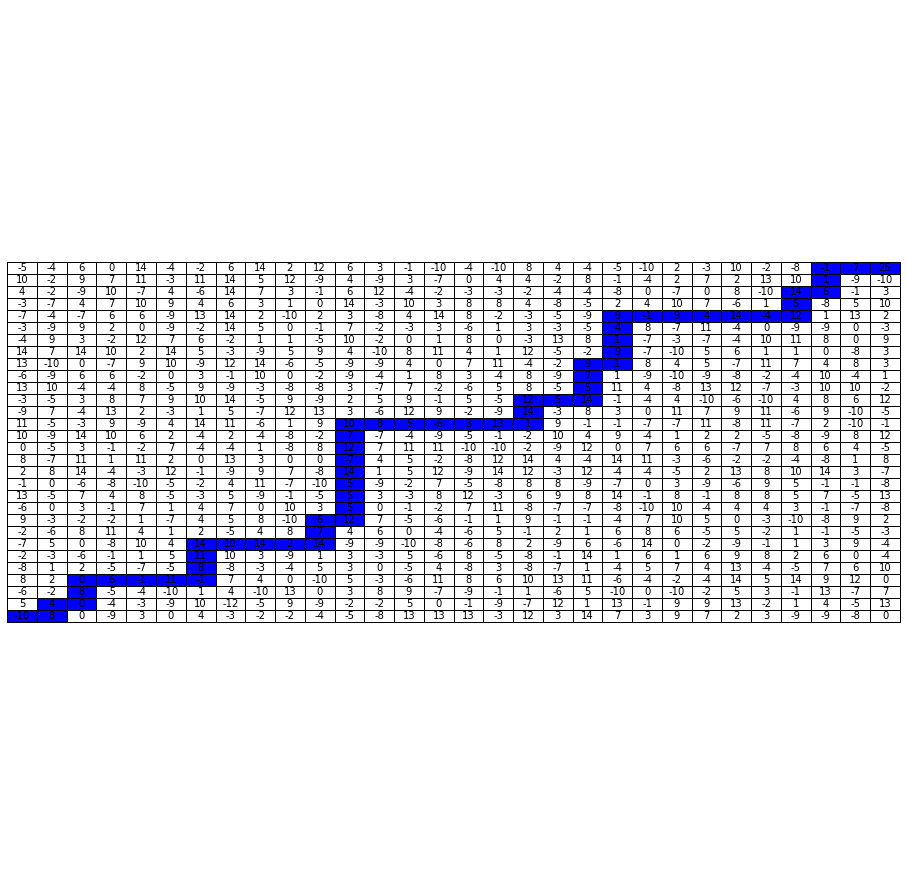

In [34]:
reward, visited_states = agent.evaluate(episodes)
print(f"reward: {reward}")
agent.plot(visited_states)

plot rewards based on the episodes. As you now, this not the best rewards, beacuase in each state, there are probabilistic actions.

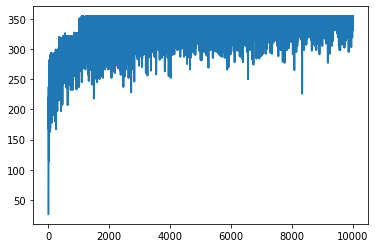

In [39]:
plt.plot(agent.rewards, linewidth=2)

the following plot is the same to above plot, but it takes only frist 1000 episodes because learning is done almost in this part.

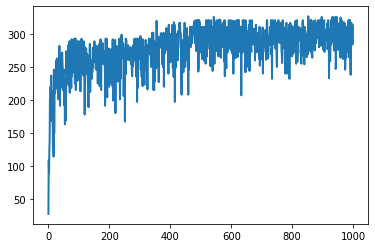

In [40]:
plt.plot(agent.rewards[:1000], linewidth=2)